# Triples Submission and Multi Agent Simulation


In [1]:
import time
from queue import Queue
import random
from typing import List
import copy

from tqdm import tqdm
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# Triple and Agent Objects

In [11]:
from mesa import Agent as MesaAgent
from mesa import Model
from mesa.time import RandomActivation

from enum import Enum
class TripleStatus(Enum):
    PENDING = 1
    ACCEPTED = 2
    REJECTED = 3

class Triple:
    
    def __init__(self,
                 source_entity: int,
                 submitter,
                 gt_validated: bool = False,
                 triple_submission_reward: float = 5,
                 triple_submission_slash: float = 1,
                 triple_validation_reward: float = 1,
                 triple_validation_slash: float = 1,
                ):
        self.source_entity = source_entity
        self.submitter = submitter
        
        self.status = TripleStatus.PENDING
        
        self.accepts = []
        self.rejects = []
        
        self.gt_validated = gt_validated
    
        self.triple_submission_reward = triple_submission_reward
        self.triple_submission_slash = triple_submission_slash
        self.triple_validation_reward = triple_validation_reward
        self.triple_validation_slash = triple_validation_slash
                
    def __repr__(self):
        return f"""Triple ID: {self.source_entity}
        submitted by: {self.submitter.agent_id}
        num_accepts: {len(self.accepts)}
        num_rejects: {len(self.rejects)}
        """
    
    def accepted(self):
        total_votes = len(self.accepts) + len(self.rejects)
        accept_ratio = len(self.accepts)/(total_votes+1)
        p_thresh = .9  # accept_ratio threshold to validate
        q_thresh = 10  # minimum votes to validate

        return total_votes >= q_thresh and accept_ratio>p_thresh
    
    def rejected(self):
        total_votes = len(self.accepts) + len(self.rejects)
        accept_ratio = len(self.accepts)/(total_votes+1)
        p_thresh = .1  # accept_ratio threshold to validate
        q_thresh = 10  # minimum votes to validate

        return total_votes >= q_thresh and accept_ratio < p_thresh
    
    def add_reject(self, agent):
        assert self.status == TripleStatus.PENDING
        self.rejects.append(agent)
        if self.rejected():
            self.status = TripleStatus.REJECTED
            # Move in agent's submitted pool
            self.submitter.submitted_triples["pending"].remove(self)
            self.submitter.submitted_triples["rejected"].append(self)
            for agent in self.rejects:
                agent.tokens_earned += self.triple_validation_reward
                agent.rewarded_validations.append(self)
            for agent in self.accepts:
                agent.staked_tokens -= self.triple_validation_slash
                agent.slashed_validations.append(self)
            self.submitter.staked_tokens -= self.triple_submission_slash
        
    def add_accept(self, agent):
        assert self.status == TripleStatus.PENDING
        self.accepts.append(agent)
        if self.accepted():
            print("accepted and rewarded")
            # Move in agent's submitted pool
            self.submitter.submitted_triples["pending"].remove(self)
            self.submitter.submitted_triples["rejected"].append(self)
            self.status = TripleStatus.ACCEPTED
            for agent in self.accepts:
                agent.tokens_earned += self.triple_validation_reward
                agent.rewarded_validations.append(self)
            for agent in self.rejects:
                agent.staked_tokens -= self.triple_validation_slash
                agent.slashed_validations.append(self)
            self.submitter.tokens_earned += self.triple_submission_reward
        

class Agent(MesaAgent):
    
    def __init__(self,
                 agent_id: int,
                 model,
                 staked_tokens = 100,
                 submission_rate: int = 90,
                 validation_rate: int = 60,
                 triple_submission_reward: float = 5,
                 triple_submission_slash: float = 1,
                 triple_validation_reward: float = 1,
                 triple_validation_slash: float = 1,
                 gt_validation_ratio: float = .9,
                ):
        super().__init__(agent_id, model)
        self.agent_id = agent_id 
        
        self.staked_tokens = staked_tokens
        self.tokens_earned = 0
        
        self.reputation = 0 # normalized between -1 and 1, 0 is neutral
        
        self.submission_rate = submission_rate
        self.validation_rate = validation_rate
                
        self.submitted_triples = {
            "pending": [],
            "accepted": [],
            "rejected": [],
        }
        
        # Might get memory intensive
        self.rewarded_validations = []
        self.slashed_validations = []
        
        self.triple_submission_reward = triple_submission_reward
        self.triple_submission_slash = triple_submission_slash
        self.triple_validation_reward = triple_validation_reward
        self.triple_validation_slash = triple_validation_slash
        self.gt_validation_ratio = gt_validation_ratio
        
    def __repr__(self):
        return f"""Agent: {self.agent_id}
        Has {self.staked_tokens} tokens staked.
        Has {self.tokens_earned} tokens earned.
        Reputation: {self.reputation}
        Pending Triples: {len(self.submitted_triples["pending"])}
        Accepted Triples: {len(self.submitted_triples["accepted"])}
        Rejected Triples: {len(self.submitted_triples["rejected"])}
        Rewarded Validations: {len(self.rewarded_validations)}
        Slashed Validations: {len(self.slashed_validations)}
        """
    
    def __hash__(self):
        return hash(self.agent_id)

    def submit_entity(self):
        for i in range(0, 5):
            submit_triple(1)
        
    def submit_triple(self, entity = 1):
        # create a triple in the graph submitted by this agent and adds to their submitted_triples
        self.submitted_triples["pending"].append(Triple(
            entity,
            self,
            triple_submission_reward = self.triple_submission_reward,
            triple_submission_slash = self.triple_submission_slash,
            triple_validation_reward = self.triple_validation_reward,
            triple_validation_slash = self.triple_validation_slash,
        ))
        
    def submitted_triples_available_to_validate(self):
        # returns: array of oldest X triples from submitted_triples queue not yet accepted or rejected where X is determined by remaining staked_tokens
        return [t for t in self.submitted_triples["pending"]][:self.staked_tokens]
    
    # Mesa Step
    def step(self):
        # Get current step count (Seconds)
        t_step = self.model.schedule.steps
        # Get agents pool
        agents = self.model.schedule.agents
        
        # Submit triple
        if t_step%self.submission_rate==0:
            self.submit_triple(randint(0,1000))

        # Validate triple
        if t_step%self.validation_rate==0:
            # Can't validate when out of staked tokens
            if self.staked_tokens <= 0:
                return

            # Agent begins validation by retrieving triple from "queue"
            triples = np.concatenate([t for t in [a.submitted_triples_available_to_validate() for a in agents]]).flat
            # pick triple from triples
            triple = random.choice(triples)

            if not triple:
                return

            # Agent will validate triple here
            if triple.gt_validated:
                agent_will_validate = bool(np.random.choice([0,1], p =[1-self.gt_validation_ratio, self.gt_validation_ratio]))  # Adding some randomness based on grounds truth validation ratio
                if agent_will_validate:
                    triple.add_accept(self)
                else:
                    triple.add_reject(self)
            else:
                agent_will_not_validate = bool(np.random.choice([0,1], p =[1-self.gt_validation_ratio, self.gt_validation_ratio]))  # Adding some randomness based on grounds truth validation ratio
                if agent_will_not_validate:
                    triple.add_reject(self)
                else:
                    triple.add_accept(self)

            # Show Agent State
            #agents_staked_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).staked_tokens
            #agents_earned_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).tokens_earned

## Mesa Model

### Generate Triples and Agent State

In [12]:
from random import randint, choice

# Initialize Triple and Agent State

# Triples State variables
sim_configs = {
    "gt_validation_ratio": .8,  # Percentage of triples that have a grounds truth validated (it's a canon triple)
    "triple_validation_reward": 1,  # Value of triple
    "triple_validation_slash": 1,  # Value of triple
    "triple_submission_reward": 5,  # 
    "triple_submission_slash": 1,  #  


    # Agent State variables
    "number_of_agents": 100,  # Number of agents, these agents will be submitting and validating triples
    "initial_token_amount": 100,  # Initial stake
    "initial_reputation": 0,  # Initial reputation
    "validation_rate": 60,  # Validation rate per second
    "submission_rate": 180,  # Submission rate per second

    # Sim Model variables
    "time_frame": 60*60*8,
}


# Create Identical Agents for simplicity(will change them up later)
class AgentModel(Model):
    
    def __init__(self, sim_configs: dict):
        self.num_agents = sim_configs["number_of_agents"]
        self.schedule = RandomActivation(self)
        
        # Sim variables
        self.staked_tokens = sim_configs["initial_token_amount"]
        self.validation_rate = sim_configs["validation_rate"]
        self.submission_rate = sim_configs["submission_rate"]
        self.triple_submission_reward = sim_configs["triple_submission_reward"]
        self.triple_submission_slash = sim_configs["triple_submission_slash"]
        self.triple_validation_reward = sim_configs["triple_validation_reward"]
        self.triple_validation_slash = sim_configs["triple_validation_slash"]
        self.gt_validation_ratio = sim_configs["gt_validation_ratio"]
        
        for i in range(self.num_agents):
            a = Agent(
                agent_id=i,
                model=self,
                staked_tokens=self.staked_tokens, 
                validation_rate=self.validation_rate+i,
                submission_rate=self.submission_rate+i,
                triple_submission_reward=self.triple_submission_reward,
                triple_submission_slash=self.triple_submission_slash,
                triple_validation_reward=self.triple_validation_reward,
                triple_validation_slash=self.triple_validation_slash,
                gt_validation_ratio=self.gt_validation_ratio,
            )
            self.schedule.add(a)
    
    def step(self):
        self.schedule.step()

In [13]:
model = AgentModel(sim_configs)
for i in tqdm(range(sim_configs["time_frame"])):
    model.step()

100%|██████████| 28800/28800 [01:46<00:00, 270.24it/s]


In [8]:
sim_configs

{'gt_validation_ratio': 0.8,
 'triple_validation_reward': 1,
 'triple_validation_slash': 1,
 'triple_submission_reward': 5,
 'triple_submission_slash': 1,
 'number_of_agents': 100,
 'initial_token_amount': 100,
 'initial_reputation': 0,
 'validation_rate': 60,
 'submission_rate': 180,
 'time_frame': 28800}

In [6]:
model.schedule.steps

28800

In [89]:
sum([len(agent.submitted_triples) for agent in model.schedule.agents])

12804

In [14]:
model.schedule.agents

[Agent: 0
         Has 98 tokens staked.
         Has 19 tokens earned.
         Reputation: 0
         Pending Triples: 160
         Accepted Triples: 0
         Rejected Triples: 0
         Rewarded Validations: 19
         Slashed Validations: 2
         ,
 Agent: 1
         Has 98 tokens staked.
         Has 20 tokens earned.
         Reputation: 0
         Pending Triples: 159
         Accepted Triples: 0
         Rejected Triples: 1
         Rewarded Validations: 20
         Slashed Validations: 1
         ,
 Agent: 2
         Has 97 tokens staked.
         Has 24 tokens earned.
         Reputation: 0
         Pending Triples: 156
         Accepted Triples: 0
         Rejected Triples: 3
         Rewarded Validations: 24
         Slashed Validations: 0
         ,
 Agent: 3
         Has 97 tokens staked.
         Has 15 tokens earned.
         Reputation: 0
         Pending Triples: 156
         Accepted Triples: 0
         Rejected Triples: 2
         Rewarded Validations: 15
   

### Visualize Agents State

In [21]:
pd.DataFrame([agent.__dict__ for agent in agents_state])

,agent_id,staked_tokens,tokens_earned,reputation,submission_rate,validation_rate,submitted_triples
0,0,100,0,0,60,60,[]
1,1,100,0,0,61,61,[]
2,2,100,0,0,62,62,[]
3,3,100,0,0,63,63,[]
4,4,100,0,0,64,64,[]
...,...,...,...,...,...,...,...
95,95,100,0,0,155,155,[]
96,96,100,0,0,156,156,[]
97,97,100,0,0,157,157,[]
98,98,100,0,0,158,158,[]


### Multi Agent Triple Validation 

In [23]:
# State Vars
agents_state

# Economy Vars
transaction_fees = 0.02
staking_fees = 0.02

# Sim Vars
time_frame = 60*60*8 # How long to run sim by seconds 

def run_triple_validation_sim(
    transaction_fees = transaction_fees,
    staking_fees = staking_fees,
    time_frame = time_frame,
):
    
    agents_staked_overtime = pd.DataFrame()
    agents_earned_overtime = pd.DataFrame()
    # Every loop is a second
    for t in tqdm(range(time_frame)):
        # Every second we have a potential agent action/policy in cadcad
        for agent in agents_state:
            if t%agent.submission_rate==0:
                agent.submit_triple(randint(0,1000))

            # Agent validates a triple
            if t%agent.validation_rate==0:
                if agent.staked_tokens <= 0:
                    continue

                # Agent begins validation by retrieving triple from "queue"
                triples = np.concatenate([t for t in [a.submitted_triples_available_to_validate() for a in agents_state]]).flat
                # pick triple from triples
                triple = random.choice(triples)
                
                if not triple:
                    continue
                
                # Agent will validate triple here
                if triple.gt_validated:
                    agent_will_validate = bool(np.random.choice([0,1], p =[1-GT_VALIDATION_RATIO, GT_VALIDATION_RATIO]))  # Adding some randomness based on grounds truth validation ratio
                    if agent_will_validate:
                        triple.add_accept(agent)
                    else:
                        triple.add_reject(agent)
                else:
                    agent_will_not_validate = bool(np.random.choice([0,1], p =[1-GT_VALIDATION_RATIO, GT_VALIDATION_RATIO]))  # Adding some randomness based on grounds truth validation ratio
                    if agent_will_not_validate:
                        triple.add_reject(agent)
                    else:
                        triple.add_accept(agent)
                                    
                # Show Agent State
                agents_staked_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).staked_tokens
                agents_earned_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).tokens_earned
    return agents_staked_overtime, agents_earned_overtime
agents_staked_overtime, earned = run_triple_validation_sim()

  0%|          | 118/28800 [00:00<00:47, 599.55it/s]/tmp/ipykernel_494/3069315403.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  agents_staked_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).staked_tokens
/tmp/ipykernel_494/3069315403.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  agents_earned_overtime[t] = pd.DataFrame([agent.__dict__ for agent in agents_state]).tokens_earned
100%|██████████| 28800/28800 [05:06<00:00, 93.95it/s] 


In [24]:
agents_state_df = pd.DataFrame([agent.__dict__ for agent in agents_state])

In [25]:
agents_state_df

,agent_id,staked_tokens,tokens_earned,reputation,submission_rate,validation_rate,submitted_triples
0,0,98,1,0,60,60,[9->\n submitted by: Agent: 0\n ...
1,1,99,2,0,61,61,[742->\n submitted by: Agent: 1\n ...
2,2,100,1,0,62,62,[989->\n submitted by: Agent: 2\n ...
3,3,100,5,0,63,63,[1->\n submitted by: Agent: 3\n ...
4,4,100,2,0,64,64,[5->\n submitted by: Agent: 4\n ...
...,...,...,...,...,...,...,...
95,95,100,1,0,155,155,[299->\n submitted by: Agent: 95\n ...
96,96,100,1,0,156,156,[860->\n submitted by: Agent: 96\n ...
97,97,100,0,0,157,157,[720->\n submitted by: Agent: 97\n ...
98,98,100,1,0,158,158,[91->\n submitted by: Agent: 98\n ...


<AxesSubplot:title={'center':'Agent Reward Overtime'}, xlabel='Time (sec)', ylabel='Tokens ($)'>

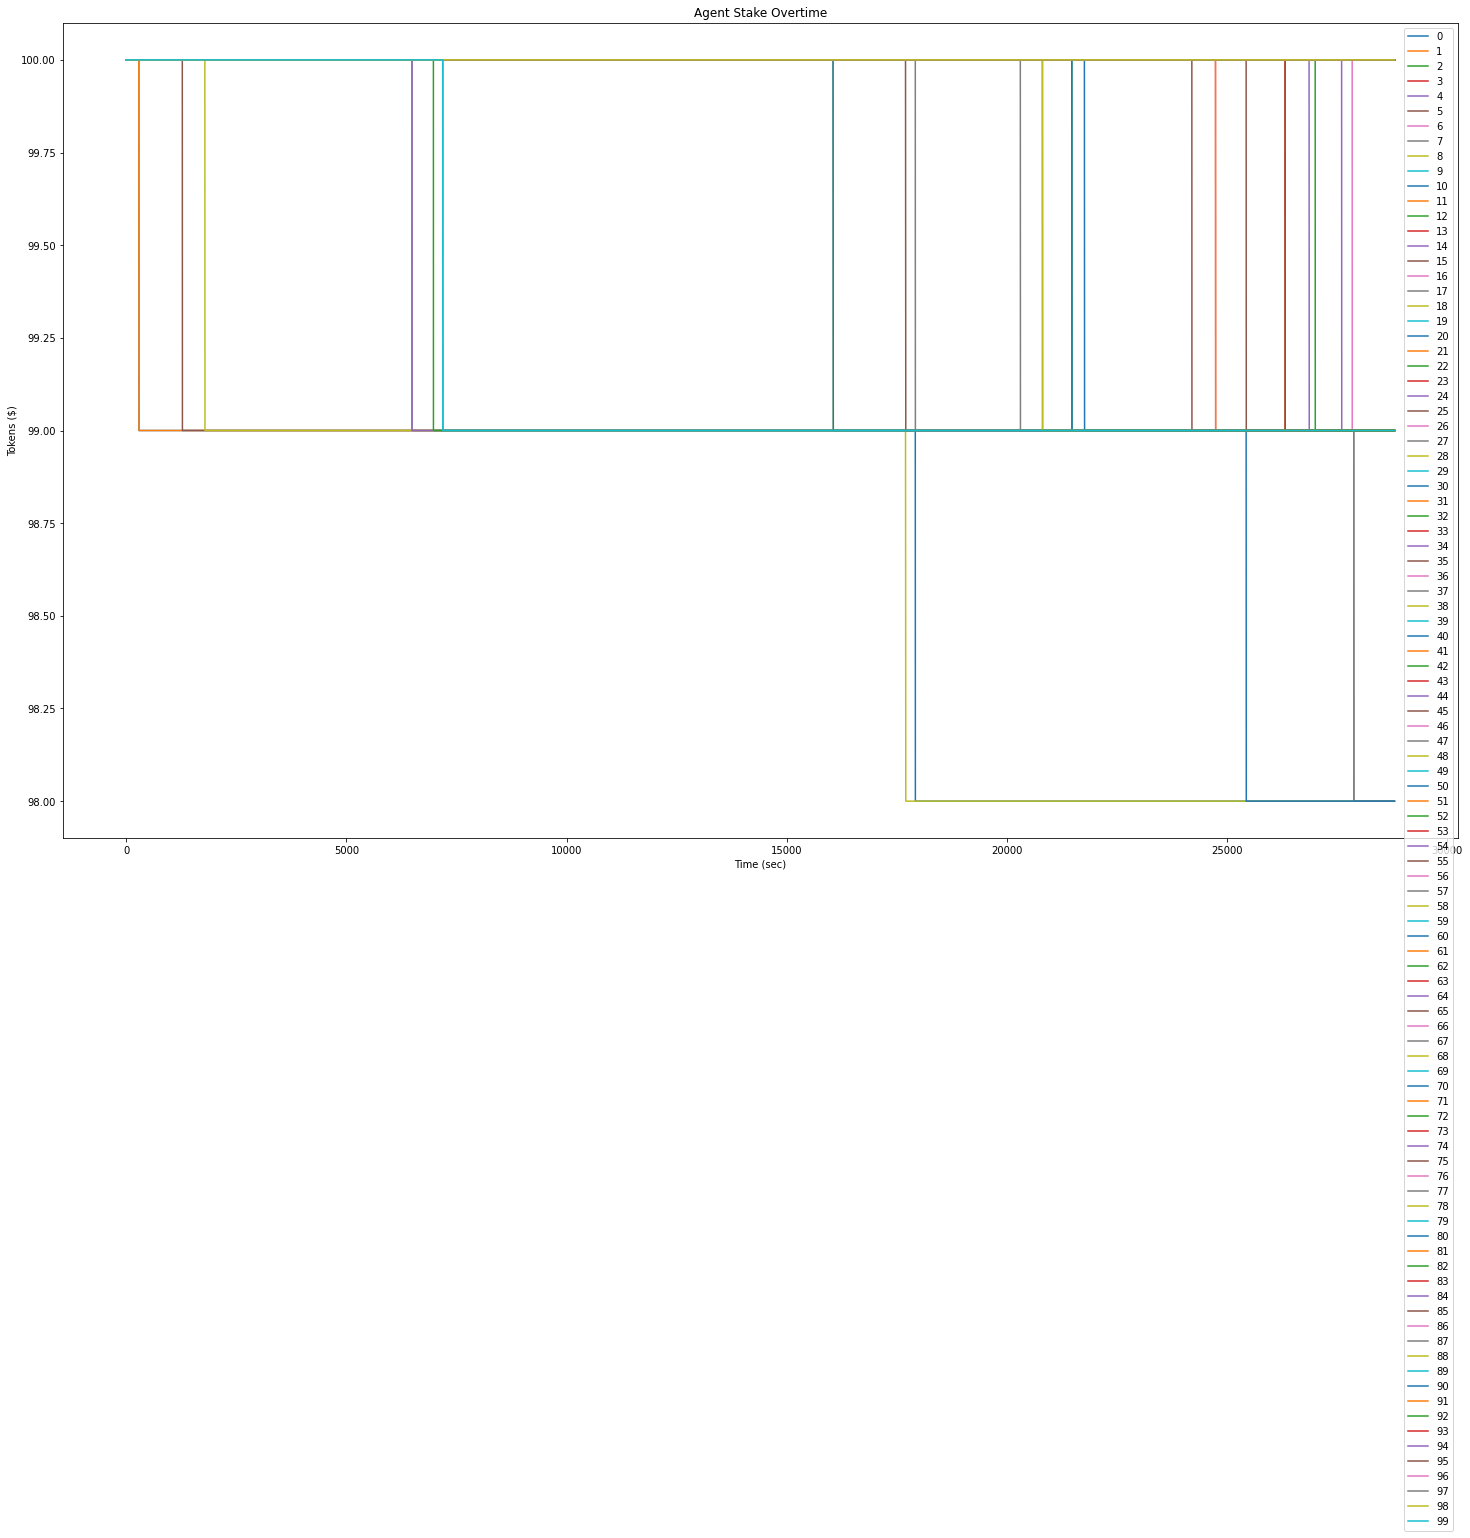

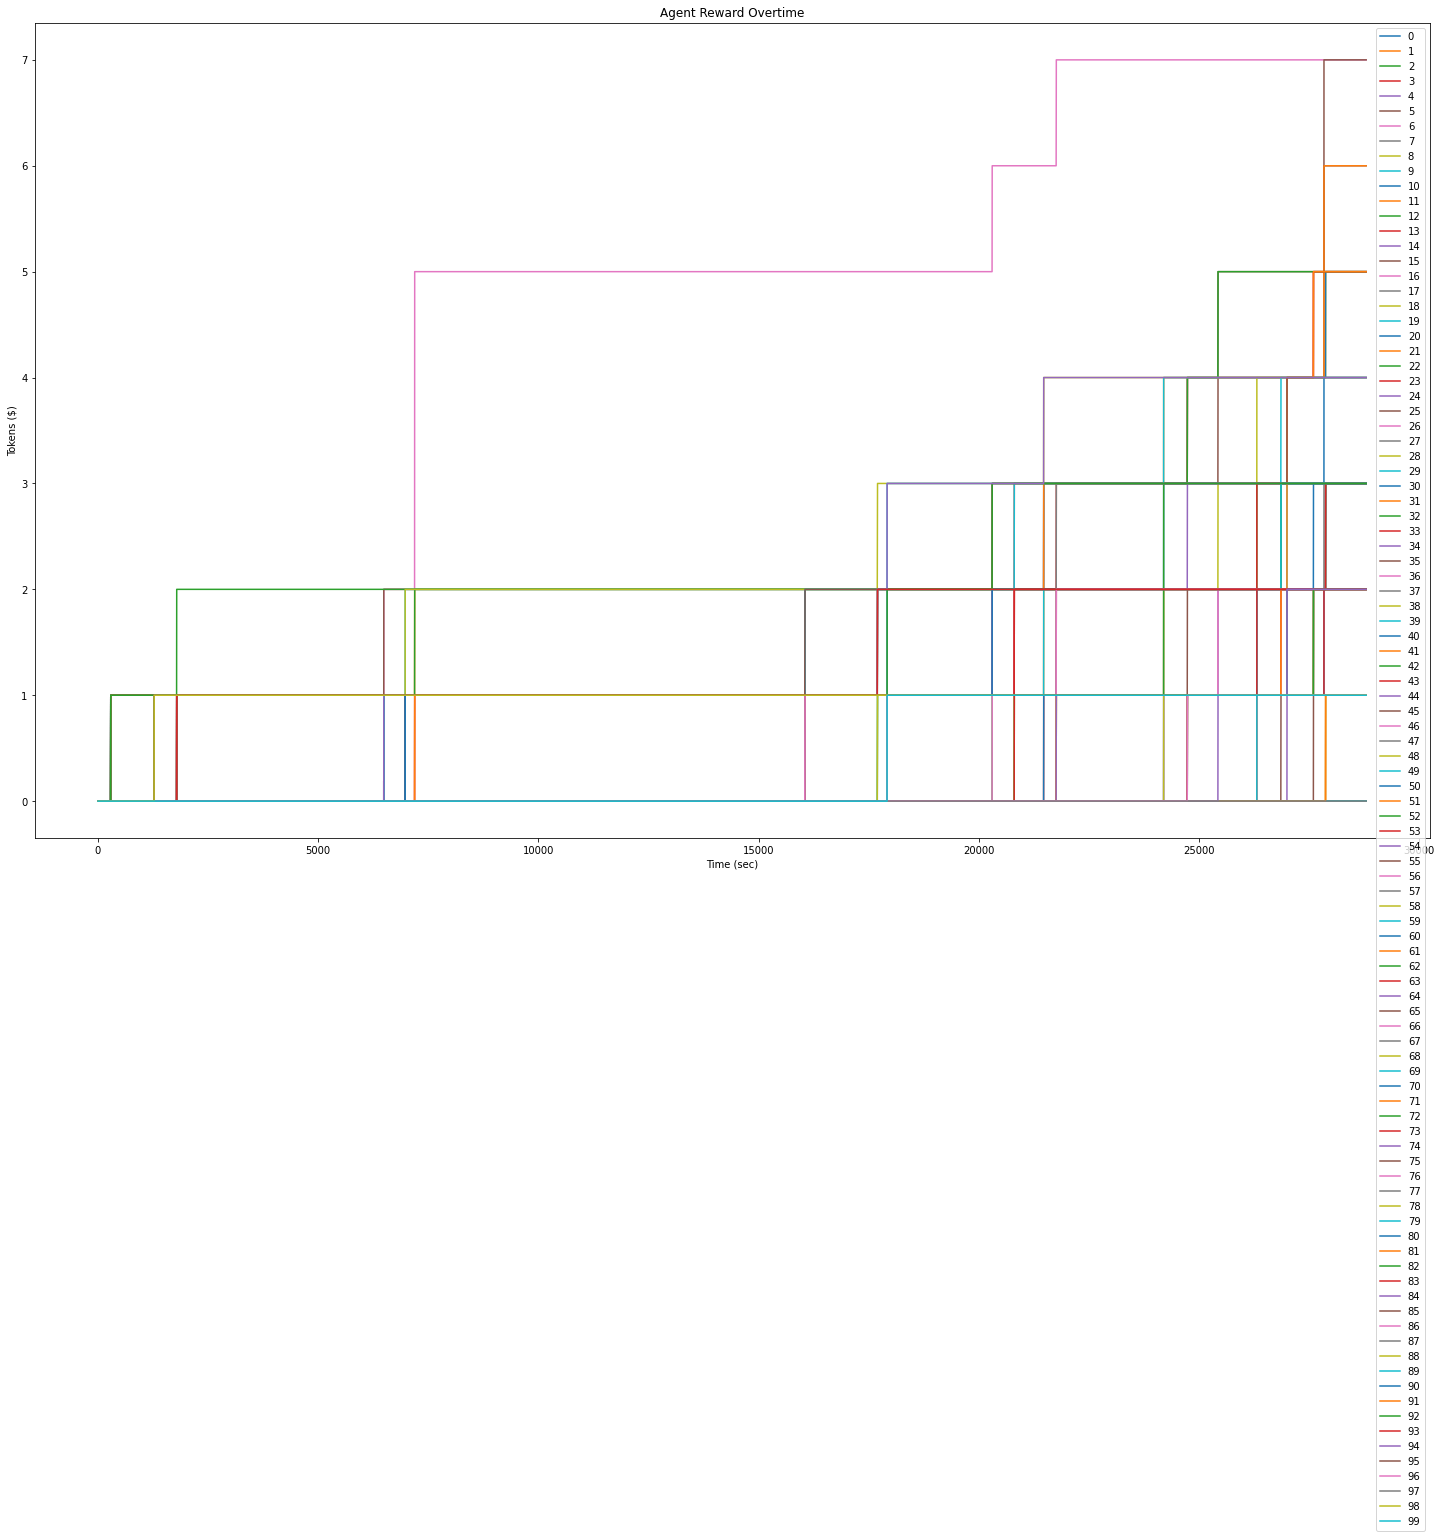

In [26]:
agents_staked_overtime.T.plot(figsize=(25, 15), title="Agent Stake Overtime", xlabel="Time (sec)", ylabel="Tokens ($)")
earned.T.plot(figsize=(25, 15), title="Agent Reward Overtime", xlabel="Time (sec)", ylabel="Tokens ($)")

In [ ]:
print(f"Sim was run for {time_frame} second(s)/{time_frame/60} minute(s)/{time_frame/3600} hour(s)")
print(f"Likelihood of submission to be validated is {validation_likelihood}%")
print(f"Transaction fee ($): {transaction_fees}")
print(f"Average task value ($): {average_task_value}")
print(f"Average time to complete entity submission (sec): {time_to_complete_submission_task}")
print("_______________________________________Sim Results____________________________________________")
print(f"Agent's total earnings over {time_frame} second(s)/{time_frame/60} minute(s)/{time_frame/3600} hour(s): \n${agent_total_reward}")

print(f"Earnings per second: ${agent_total_reward/(time_frame)}")
print(f"Earnings per minute: ${agent_total_reward/(time_frame/60)}")
print(f"Earnings per hour: ${agent_total_reward/(time_frame/3600)}")

In [ ]:
# Economy Vars
transaction_fees = 0.05
average_task_value = 0.2
time_to_complete_submission_task = 60
validation_accept_score = 0
validation_reject_score = 0
total_validation_submissions = validation_accept_score+validation_reject_score

# Sim Vars
time_frame = 60*60*8 # How long to run sim by seconds 
agent_total_reward = 0 # Cumulative rewards of single agent
validation_likelihood = 0.85 # How likely it is the agent's entity submission is validated

def run_triple_validation_sim(
    transaction_fees = transaction_fees,
    average_task_value = average_task_value,
    time_to_complete_submission_task = time_to_complete_submission_task,
    time_frame = time_frame,
    agent_total_reward = agent_total_reward,
    validation_likelihood = validation_likelihood,
    total_validation_submissions = total_validation_submissions,
):
    tracked_agent_total_reward = []
    # Every loop is a second
    for t in range(time_frame):
        if t%time_to_complete_submission_task==0:
            agent_total_reward -= transaction_fees
            successfully_validated = np.random.choice(np.arange(0,2), p=[1-validation_likelihood, validation_likelihood])
            if total_validation_submissions ==0:
                agent_total_reward += (average_task_value * successfully_validated)
            else:
                agent_total_reward += (average_task_value * successfully_validated)*(1/(total_validation_submissions))
            tracked_agent_total_reward.append(agent_total_reward)
        else:
            continue
    return agent_total_reward, tracked_agent_total_reward

agent_total_reward, _ = run_triple_validation_sim()

In [ ]:
print(f"Sim was run for {time_frame} second(s)/{time_frame/60} minute(s)/{time_frame/3600} hour(s)")
print(f"Likelihood of submission to be validated is {validation_likelihood}%")
print(f"Transaction fee ($): {transaction_fees}")
print(f"Average task value ($): {average_task_value}")
print(f"Average time to complete entity submission (sec): {time_to_complete_submission_task}")
print("_______________________________________Sim Results____________________________________________")
print(f"Agent's total earnings over {time_frame} second(s)/{time_frame/60} minute(s)/{time_frame/3600} hour(s): \n${agent_total_reward}")

print(f"Earnings per second: ${agent_total_reward/(time_frame)}")
print(f"Earnings per minute: ${agent_total_reward/(time_frame/60)}")
print(f"Earnings per hour: ${agent_total_reward/(time_frame/3600)}")

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

# Economy Vars
transaction_fees = 0.05
average_task_value = 0.2
time_to_complete_submission_task = 60
validation_accept_score = 0
validation_reject_score = 0
total_validation_submissions = validation_accept_score+validation_reject_score

# Sim Vars
time_frame = 60*60*8 # How long to run sim by seconds 
agent_total_reward = 0 # Cumulative rewards of single agent
validation_likelihood = 0.85 # How likely it is the agent's entity submission is validated

# Set plot dimensions corresponding to how many actions occur
num_actions = int(time_frame/time_to_complete_submission_task) # Number of agent actions to occur over time
x_dim = np.linspace(0,time_frame/60-1, num=num_actions) # Max is num actions obviously
y_dim = np.linspace(0,num_actions*average_task_value, num=num_actions) # Number of actions x average task value

# Get figure and label accordingly
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Single Agent on Triple Validation Task")
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Reward Earned ($)")

# Plot initial line and point objects to manipulate
line = ax.plot(x_dim, y_dim)[0]
hourly_point = ax.plot([60],[0], 'ro')[0]
hourly_point_text = ax.text(1, 0+1, f"$0/hour")

def update(
    transaction_fees = transaction_fees,
    average_task_value = average_task_value,
    validation_likelihood = validation_likelihood,
    total_validation_submissions = total_validation_submissions,
):
    # Local vars use the "global" set vars
    agent_total_reward, tracked_agent_total_reward = run_triple_validation_sim(
        **locals(),
        time_frame=time_frame,
        time_to_complete_submission_task=time_to_complete_submission_task,
        agent_total_reward=0,
    )
    
    # Update and set line showing agent's total reward output based on time
    line.set_ydata(tracked_agent_total_reward)
    line.set_marker('o') # Set markers
    
    # Plot the point of hourly rate
    hourly_reward = agent_total_reward/(time_frame/3600) # Get total reward per hour
    hourly_point.set_data([60], [hourly_reward])
    hourly_point_text.set_text(f"${str(round(hourly_reward,2))}/hour")
    hourly_point_text.set_x(60)
    hourly_point_text.set_y(hourly_reward)
    
    # Draw
    fig.canvas.draw_idle()

    

interact(
    update,
    transaction_fees = (0,transaction_fees*3, .01),
    average_task_value = (0, average_task_value*3, .01),
    validation_likelihood = (0,1,.01),
    total_validation_submissions = (0,100,1),
);

In [ ]:
np.random.RandomState(1)

In [ ]:
import numpy as np
from datetime import timedelta

from cadCAD.configuration.utils import bound_norm_random, config_sim, time_step, env_trigger
from cadCAD.configuration import Experiment
from documentation.examples import system_model_AB_exp

seeds = {
    'z': np.random.RandomState(1),
    'a': np.random.RandomState(2),
    'b': np.random.RandomState(3),
    'c': np.random.RandomState(4)
}


# Policies per Mechanism
def p1m1(_g, step, sH, s):
    return {'param1': 1}
def p2m1(_g, step, sH, s):
    return {'param1': 1, 'param2': 4}

def p1m2(_g, step, sH, s):
    return {'param1': 'a', 'param2': 2}
def p2m2(_g, step, sH, s):
    return {'param1': 'b', 'param2': 4}

def p1m3(_g, step, sH, s):
    return {'param1': ['c'], 'param2': np.array([10, 100])}
def p2m3(_g, step, sH, s):
    return {'param1': ['d'], 'param2': np.array([20, 200])}


# Internal States per Mechanism
def s1m1(_g, step, sH, s, _input):
    y = 's1'
    x = s['s1'] + 1
    return (y, x)
def s2m1(_g, step, sH, s, _input):
    y = 's2'
    x = _input['param2']
    return (y, x)

def s1m2(_g, step, sH, s, _input):
    y = 's1'
    x = s['s1'] + 1
    return (y, x)
def s2m2(_g, step, sH, s, _input):
    y = 's2'
    x = _input['param2']
    return (y, x)

def s1m3(_g, step, sH, s, _input):
    y = 's1'
    x = s['s1'] + 1
    return (y, x)
def s2m3(_g, step, sH, s, _input):
    y = 's2'
    x = _input['param2']
    return (y, x)

def policies(_g, step, sH, s, _input):
    y = 'policies'
    x = _input
    return (y, x)


# Exogenous States
proc_one_coef_A = 0.7
proc_one_coef_B = 1.3

def es3(_g, step, sH, s, _input):
    y = 's3'
    x = s['s3'] * bound_norm_random(seeds['a'], proc_one_coef_A, proc_one_coef_B)
    return (y, x)

def es4(_g, step, sH, s, _input):
    y = 's4'
    x = s['s4'] * bound_norm_random(seeds['b'], proc_one_coef_A, proc_one_coef_B)
    return (y, x)

def update_timestamp(_g, step, sH, s, _input):
    y = 'timestamp'
    return y, time_step(dt_str=s[y], dt_format='%Y-%m-%d %H:%M:%S', _timedelta=timedelta(days=0, minutes=0, seconds=1))


# Genesis States
genesis_states = {
    's1': 0.0,
    's2': 0.0,
    's3': 1.0,
    's4': 1.0,
    'timestamp': '2018-10-01 15:16:24'
}


# Environment Process
trigger_timestamps = ['2018-10-01 15:16:25', '2018-10-01 15:16:27', '2018-10-01 15:16:29']
env_processes = {
    "s3": [lambda _g, x: 5],
    "s4": env_trigger(3)(trigger_field='timestamp', trigger_vals=trigger_timestamps, funct_list=[lambda _g, x: 10])
}


psubs = [
    {
        "policies": {
            "b1": p1m1,
            "b2": p2m1
        },
        "variables": {
            "s1": s1m1,
            "s2": s2m1,
            "s3": es3,
            "s4": es4,
            "timestamp": update_timestamp
        }
    },
    {
        "policies": {
            "b1": p1m2,
            "b2": p2m2
        },
        "variables": {
            "s1": s1m2,
            "s2": s2m2,
            # "s3": es3p1,
            # "s4": es4p2,
        }
    },
    {
        "policies": {
            "b1": p1m3,
            "b2": p2m3
        },
        "variables": {
            "s1": s1m3,
            "s2": s2m3,
            # "s3": es3p1,
            # "s4": es4p2,
        }
    }
]


sim_config = config_sim(
    {
        "N": 2,
        "T": range(1),
    }
)

exp = Experiment()
exp.append_model(
    model_id='sys_model_A',
    sim_configs=sim_config,
    initial_state=genesis_states,
    env_processes=env_processes,
    partial_state_update_blocks=psubs,
    policy_ops=[lambda a, b: a + b]
)

system_model_AB_exp.append_model(
    model_id='sys_model_A',
    sim_configs=sim_config,
    initial_state=genesis_states,
    env_processes=env_processes,
    partial_state_update_blocks=psubs,
    policy_ops=[lambda a, b: a + b]
)

In [ ]:
from cadCAD.engine import Executor, ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

In [ ]:
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)

In [ ]:
import pandas as pd
raw_system_events, tensor_field, sessions = simulation.execute()

# Simulation Result Types:
# raw_system_events: List[dict] 
# tensor_field: pd.DataFrame

# Result System Events DataFrame
simulation_result = pd.DataFrame(raw_system_events)

In [ ]:
simulation_result

In [ ]:
import pandas as pd
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from documentation.examples import sys_model_A
from documentation.examples.sys_model_A import exp

exec_mode = ExecutionMode()

# Single Process Execution using a Single System Model Configuration:
# sys_model_A
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
sys_model_A_simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)

sys_model_A_raw_result, sys_model_A_tensor_field, sessions = sys_model_A_simulation.execute()
sys_model_A_result = pd.DataFrame(sys_model_A_raw_result)
print()
print("Tensor Field: sys_model_A")
print(tabulate(sys_model_A_tensor_field, headers='keys', tablefmt='psql'))
print("Result: System Events DataFrame")
print(tabulate(sys_model_A_result, headers='keys', tablefmt='psql'))
print()

Derive with parameterized variables:

Just make cost and reward constant values.

- Triple Validation Cost: $C(V)_{user} = $$rep_{user}$$a_{task}$$r_{task}$$l_{task}$
- Triple Validation Reward: $R(V)_{user} = $$rep_{user}$$a_{task}$$r_{task}$$l_{task}$

In [ ]:
import random

def sim_validation_task(source_id=1, target_id=74, accept_bounds: list= [0,100], reject_bounds: list = [0,100], rep_bounds: list=[0,1000]):
    num_accepts = random.randint(*accept_bounds)
    num_rejects = random.randint(*reject_bounds)
    rep_score = random.randint(*rep_bounds)
    validation_ratio = num_accepts/(num_accepts+num_rejects)
    lp_scores = link_prediction_scores(source_id=1, target_id=74)
    return num_accepts, num_rejects, validation_ratio, lp_scores, rep_score

In [ ]:
num_accepts, num_rejects, validation_ratio, lp_scores, rep_score = sim_validation_task(source_id=1, target_id=74)

In [ ]:
lp_scores

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x_dim = np.linspace(0,2, num=100)
y_dim = np.linspace(-1,1, num=100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x_dim, y_dim)[0]

jaccard_coeff = lp_scores["jaccard_coefficient"]

def update(jaccard_coeff=jaccard_coeff):
    line.set_ydata(y_dim*jaccard_coeff)
    fig.canvas.draw_idle()


interact(update, jaccard_coeff=(-1, 1, .01));

In [ ]:
validation_ratio

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x_dim = np.linspace(0,2, num=100)
y_dim = np.linspace(-1,1, num=100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x_dim, y_dim)[0]


def update(validation_ratio=validation_ratio):
    line.set_ydata(y_dim*validation_ratio)
    fig.canvas.draw_idle()


interact(update, validation_ratio=(-1, 1, .01));

In [ ]:
rep_score

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x_dim = np.linspace(0,100, num=100)
y_dim = np.linspace(0,1000, num=100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x_dim, y_dim)[0]


def update(rep_score=rep_score, coeff=.001):
    line.set_ydata(y_dim*rep_score*coeff)
    fig.canvas.draw_idle()


interact(update, rep_score=(0, 1000, 1), coeff=(0, .01, .0001));

In [ ]:
from typing import List, Union, Tuple

import requests


URLs = {
    "annotations":"http://annotations.project.local:5000",
    "question-answering":"http://question-answering.project.local:5001",
    "summarization":"http://summarization.project.local:5002",
    "industry-classification":"http://industry-classification.project.local:5003",
    "vector-similarity":"http://vector-similarity.project.local:5004",
    "annotations":"http://annotations.project.local:5000",
    "knowledge-graph":"http://knowledge-graph.project.local:5007"
}
# Keep Auth headers because it doesn't hurt
# Will want to auth when we add Kong gateway or ALB
API_KEY = "3J3sM4QI9RWDeiN9Dh1hCLxbGtPE2DhL"
AUTH_HEADER = {"apikey": API_KEY}

def question_answering(
    query: Union[str, List[str]], context: Union[str, List[str]], top_n: int = 5
):
    """Question Answering call that takes in the following params:
    {
            query: ["What is the answer?"]
            context: ["Here is the answer among this text"]
            top_n: 10
    }
    and returns the best answer and the top n best answers:
    {
            "best_answers": [
                    "Here is the answer"
            ]
            "best_n_answers": [
                    [
                            {
                                    text: "Here is the answer
                                    "probability": 0.5296024261966407,
                                    "start_logit": 9.094000816345215,
                                    "end_logit": 9.010401725769043,
                                    "start_index": 4,
                                    "end_index": 7,
                                    "char_start_index": 19,
                                    "char_end_index": 44
                            }, ...
                    ]
            ]
    }
    """
    url = "/".join([URLs["question-answering"], "api", "question-answering"])
    if isinstance(query, str):
        query = [query]
        context = [context]
    body = {"query": query, "context": context, "top_n": top_n}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def annotate(text: str):
    """Annotation call that takes in an article text and outputs:
    {
        "tokens": [
            {
                "text": "Revolution",
                "ws": " "
            },...
        ],
        "annotations": {
            "entities": [
                {
                    "type": "Organization",
                    "coref_id": 1,
                    "first_token": 0,
                    "last_token": 2,
                    "text": "Revolution Medicines Inc"
                }, ...
            ],
            "relationships": [
                {
                    "subject": 0,
                    "object": 3,
                    "type": "Raised",
                    "event_id": "0a14b539-a384-4d5c-a622-ba714780007a"
                }, ...
            ]
        },
        "events": [
            {
                "date": {
                    "year": 2021,
                    "month": null,
                    "day": null
                },
                "contents": "Revolution Medicines Inc, a Redwood City,...
                "first_token": 0,
                "last_token": 28,
                "type": "generic",
                "uuid": "f28e108a-8f05-4842-ac48-789413fa78e0"
            }, ...
        ]
    }

    """
    url = "/".join([URLs["annotations"], "api", "annotation"])
    body = {"text": text}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def summarization(text: str, min_char_length: int = 60, max_char_length: int = 300):
    """Summarization call that condenses text within a min/max length."""
    url = "/".join([URLs["summarization"] + ":5002", "api", "summarization"])
    body = {
        "text": text,
        "min_char_length": min_char_length,
        "max_char_length": max_char_length,
    }
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def named_entity_recognition(text: str):
    """Simple named entity recognition call that takes in text and outputs:
    {
            "text": "original text",
        "entities": [
            {
                "type": "Organization",
                "start_char": 0,
                "end_char": 7,
                "text": "Google"
            }, ...
        ],
    }

    """
    url = "/".join([URLs["annotations"], "api", "named_entity_recognition"])
    body = {"text": text}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def industry_classification(text: str, num_topics: int = 5, num_terms: int = 10):
    """Industry Classification service for predicting industries based off of
    relevant entity text
    You input the text num_topics, and num_terms:
    {
            "text": "Revolution Medicines Inc, a Redwood City, Calif.
            -based developer of medicines for cancer patients, raised
            $100 million in Series C funding on December 25th 2021.
            Investors include Boxer Capital of the Tavistock Group ..."
            "num_topics": 5,
            "num_terms": 10
    }

    and the response is a list of the top topics and its terms
    predicted by num_topics and num_terms:
    {
            "results": [
                {
                    "topic_id": 212,
                    "topic_score": 0.5091588497161865,
                    "topic_terms": [
                        "cancer",
                        "cancers",
                        "tumor",
                        "donation",
                        "donations",
                        "fundraising",
                        "crowdfunding",
                        "donating",
                        "charity",
                        "donate"
                    ],
                    "industry": "Cancer-PD8EV",
                    "confidence": "strong"
                },...
            ]
    }

    """

    url = "/".join([URLs["industry-classification"], "api", "industry_classification"])
    body = {"text": text, "num_topics": num_topics, "num_terms": num_terms}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def industry_classification_from_url(
    webpage_url: str, num_topics: int = 5, num_terms: int = 10
):
    """Industry Classification service for predicting industries based off of
    relevant entity text
    You input the text num_topics, and num_terms:
    {
            "url": "https://www.golden.com"
            "num_topics": 5,
            "num_terms": 10
    }

    and the response is a list of the top topics and its terms
    predicted by num_topics and num_terms:
    {
            "results": [
                {
                    "topic_id": 212,
                    "topic_score": 0.5091588497161865,
                    "topic_terms": [
                        "cancer",
                        "cancers",
                        "tumor",
                        "donation",
                        "donations",
                        "fundraising",
                        "crowdfunding",
                        "donating",
                        "charity",
                        "donate"
                    ],
                    "industry": "Cancer-PD8EV",
                    "confidence": "strong"
                },...
            ]
    }

    """

    url = "/".join([URLs["industry-classification"], "api", "industry_classification_website"])
    body = {"url": webpage_url, "num_topics": num_topics, "num_terms": num_terms}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def text_from_url(webpage_url: str):
    """Web extraction service for predicting industries based off of
    {
        "url": "www.example.com"
    }

    {
        "meta": "",
        "content": ""
    }
    """

    url = "/".join([URLs["industry-classification"], "api", "text_from_url"])
    body = {"url": webpage_url}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def disambiguate_name(names: List[dict]):
    """Disambiguate names with goldnlp and ES
    Input should be a list of dicts formatted like:
    [{
        "name": "Golden",
        "constraints": [6],  # Entity ID for "Company"
        "aliases": ["Golden Recursion Inc."],  # optional
        "allow_null_is_a": False,
    }]

    Method will return a list of the same length, with a
    nested list of result dicts like
    [{"id": 21, "name": "Golden", "match_type": "canonical"}] for
    each input dict

    results are ordered by quality. possible match_types are:
    "canonical" - the name you put in is a match
    "base_name" - the name you put in, with a little cleanup from
                  probablepeople, is a match
    "bare_name" - like base_name, but with more aggressive cleanup
                  from probablepeople
    "alt_span_composite" - match was made on an alias you provided
    """
    url = "/".join([URLs["annotations"], "api", "disambiguate_names"])
    for n in names:
        n["name"] = n.get("name", "")
        n["constraints"] = n.get("constraints", [])
        n["aliases"] = n.get("aliases", [])
        n["allow_null_is_a"] = n.get("allow_null_is_a", False)
    body = {"names": names}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    results = r.json().get("results", [])
    return results


def summarize(
    text="",
    unit="paragraph",
    n_units=5,
    preserve_article_order=True,
    score_mode="t",
    as_signature=False,
):
    """Spacy Summarize"""
    url = "/".join([URLs["annotations"], "api", "summarize"])
    body = {
        "text": text,
        "unit": unit,
        "n_units": n_units,
        "preserve_article_order": preserve_article_order,
        "score_mode": score_mode,
        "as_signature": as_signature,
    }
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def entity_search(text: str):
    """ES entity search with spacy"""
    url = "/".join([URLs["annotations"], "api", "entity_search"])
    body = {"text": text}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def entities_and_relations(text: str):
    """ES entity and relations search with spacy"""
    url = "/".join([URLs["annotations"], "api", "entity_and_relations_search"])
    body = {"text": text}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()

def quality_check(text: str = "", slate: dict = None, warnings_only: bool = True):
    """Quality check on text or slate"""
    url = "/".join([URLs["annotations"], "api", "quality_check"])
    body = {"text": text, "slate": slate, "warnings_only": warnings_only}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json().get("quality", {})

def default_completion_query(text: str):
    """ES entity search with spacy"""
    url = "/".join([URLs["annotations"], "api", "default_completion_query"])
    body = {"text": text}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()

def semantic_disambiguate(
    name: str = "", context: str = "", constraints: Tuple = (), n_results: int = 20
):
    """Semantic disambiguate given a name and some textual context"""
    constraints = list(constraints)
    url = "/".join([URLs["vector-similarity"], "api", "semantic_disambiguate"])
    body = {
        "name": name,
        "context": context,
        "constraints": constraints,
        "n_results": n_results,
    }
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


def image_disambiugate(
    name: str = "", image_url: str = "", constraints: Tuple = (), n_results: int = 20
):
    """Semantic disambiguate given a name and some image link"""
    constraints = list(constraints)
    url = "/".join([URLs["vector-similarity"], "api", "image_disambiguate"])
    body = {
        "name": name,
        "image_url": image_url,
        "constraints": constraints,
        "n_results": n_results,
    }
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()

def link_prediction_scores(source_id:int =1, target_id:int = 74):
    """ES entity search with spacy"""
    url = "/".join([URLs["knowledge-graph"], "api", "link_prediction_scores"])
    body = {"source_entity_id": source_id,
           "target_entity_id": target_id}
    r = requests.post(url, headers=AUTH_HEADER, json=body)
    print(r.status_code, r.reason)
    return r.json()


In [ ]:
link_prediction_scores()